In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Network_bayesian import Place_net, Grid_net, Coupled_Net
import brainpy as bp
import brainpy.math as bm
from matplotlib.animation import FuncAnimation
import time
from scipy.stats import ttest_ind, norm

# Circular distance function
def circ_dis(phi_1, phi_2):
    dis = phi_1 - phi_2
    dis = np.where(dis > np.pi, dis - 2 * np.pi, dis)
    dis = np.where(dis < -np.pi, dis + 2 * np.pi, dis)
    return dis

In [ ]:
import random
# Set the random seed
seed = 1
np.random.seed(seed)
bm.random.seed(seed)
random.seed(seed)

In [ ]:
# default parameters

# grid spacing
lambda_1 = 3
lambda_2 = 4
lambda_3 = 5
Lambda = np.array([lambda_1, lambda_2, lambda_3])
M = len(Lambda)
L = lambda_1 * lambda_2 * lambda_3
# cell number
num_p = int(200)
rho_p = num_p / L
rho_g = rho_p
num_g = int(rho_g * 2 * np.pi)  # To make the rho values of the two networks equal
# feature space
x = np.linspace(0, L, num_p, endpoint=False)
theta = np.linspace(0, 2 * np.pi, num_g, endpoint=False)
# connection range
a_p = 0.3
a_g = a_p / Lambda * 2 * np.pi
# connection strength
J_p = 20
J_g = J_p
J_pg = J_p / 25

# divisive normalization
k_p = 20.
k_g = Lambda / 2 / np.pi * k_p
# time constants
tau_p = 1
tau_g = 2 * np.pi * tau_p / Lambda
# input_strength
alpha_p = 0.05
alpha_g = 0.05
# noise strength
noise_ratio = 0.007
print(num_g)
print(a_g)
print(k_g)
print(tau_g)

20
[0.62831853 0.4712389  0.37699112]
[ 9.54929659 12.73239545 15.91549431]
[2.0943951  1.57079633 1.25663706]


In [4]:
# initialization of the model
# Place cells
P_CANN = Place_net(z_min=0, z_max=L, num=num_p, a_p=a_p, k=k_p, tau=tau_p, J0=J_p)
# Grid cells
G_CANNs = bm.NodeList()
for i in range(M):
    G_CANNs.append(Grid_net(z_min=0, z_max=L, num=num_g, num_hpc=num_p, L=Lambda[i], a_g=a_g[i], k_mec=k_g[i], tau=tau_g[i], J0=J_g, W0=J_pg))
# coupled model
Coupled_model = Coupled_Net(HPC_model=P_CANN, MEC_model_list=G_CANNs, num_module=M)


In [5]:
# GOP and Net decoding functions

def GOP_decoding(z_t, phi_t, Ip, Ig, alpha_p_infer, alpha_g_infer, Ag, Ap, Rp, total_itenoise_rations=5000):
    sigma_g = np.sqrt(np.sqrt(np.pi) * Ag ** 3 * rho_g * tau_g / (a_g * alpha_g_infer))
    sigma_phi = np.sqrt(8 * np.pi * Ag * tau_g / (Lambda * J_pg * rho_p * Rp))
    sigma_p = np.sqrt(np.sqrt(np.pi) * Ap ** 3 * rho_p * tau_p / (a_p * alpha_p_infer))
    print(sigma_g, sigma_p, sigma_phi)
    sigma_g_infer = sigma_g * noise_ratio
    sigma_phi_infer = sigma_phi * noise_ratio
    sigma_p_infer = sigma_p * noise_ratio
    eta = 26. * 1e-6
    z_ts = []
    phi_ts = []
    z_ts.append(z_t)
    phi_ts.append(phi_t)
    z_encode_space = np.linspace(0, L, num_p, endpoint=False)

    for itenoise_ration in range(total_itenoise_rations):
        fg_prime = np.zeros((M, num_g))
        for i in range(M):
            dis_theta = circ_dis(theta, phi_t[i])
            fg_prime[i, :] = dis_theta / (2 * a_g[i] ** 2) * np.exp(-dis_theta ** 2 / (4 * a_g[i] ** 2))

        dis_z = z_encode_space - z_t
        fp_prime = dis_z / (2 * a_p ** 2) * np.exp(-dis_z ** 2 / (4 * a_p ** 2))
        
        Ig_fgprime_prod = Ig * fg_prime
        Ig_fgprime_prod = np.sum(Ig_fgprime_prod, axis=1)
        dphi_fr = Ig_fgprime_prod / sigma_g_infer ** 2

        Ip_fp_prime_prod = Ip * fp_prime
        Ip_fp_prime_prod = np.sum(Ip_fp_prime_prod)
        dr_fr = Ip_fp_prime_prod / sigma_p_infer ** 2

        phi_z = np.mod(z_t / Lambda, 1) * 2 * np.pi
        dis_phi = circ_dis(phi_z, phi_t)
        dphi_tr = 1 / sigma_phi_infer ** 2 * dis_phi
        dr_tr = np.sum(-2 * np.pi / (Lambda * sigma_phi_infer ** 2) * dis_phi)

        dphi = dphi_fr + dphi_tr
        phi_t = phi_t + eta * dphi
        
        phi_t = np.mod(phi_t, 2 * np.pi)
        
        dr = dr_fr + dr_tr
        z_t = z_t + eta * dr

        z_ts.append(z_t)
        phi_ts.append(phi_t)
    return np.array(z_ts), np.array(phi_ts)

def Net_decoding(z_truth, phi_truth, Ip, Ig, alpha_p=0.05, alpha_g=0.05, Coupled_model=Coupled_model):
    Coupled_model.reset_state()
    def initial_net(Ip, Ig): 
        Coupled_model.initial(alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)

    def run_net(i, Ip, Ig): 
        Coupled_model.step_run(i, alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)
        phi_decode = Coupled_model.phase
        z_decode = Coupled_model.HPC_model.center
        rp = Coupled_model.HPC_model.r
        up = Coupled_model.HPC_model.u
        rg = bm.zeros([M, num_g])
        ug = bm.zeros([M, num_g])
        for mi in range(M):
            rg[mi, :] = Coupled_model.MEC_model_list[mi].r
            ug[mi, :] = Coupled_model.MEC_model_list[mi].u
        return z_decode, phi_decode, rp, up, rg, ug

    T_init = 500
    z0 = z_truth
    phi_0 = phi_truth
    fg = np.zeros((M, num_g))
    for i in range(M):
        dis_theta = circ_dis(theta, phi_0[i])
        fg[i, :] = np.exp(-dis_theta ** 2 / (4 * a_g[i] ** 2))
    dis_x = x - z0
    fp = np.exp(-dis_x ** 2 / (4 * a_p ** 2))
    I_place = 1 * np.repeat(fp[np.newaxis, :], T_init, axis=0)
    I_grid = 1 * np.repeat(fg[np.newaxis, :, :], T_init, axis=0)
    I_place[int(T_init / 3):, :] = 0
    I_grid[int(T_init / 3):, :, :] = 0

    bm.for_loop(initial_net, (I_place, I_grid), progress_bar=False)
    T = 5000
    indices = np.arange(T)
    I_place = alpha_p * np.repeat(Ip[np.newaxis, :], T, axis=0)
    I_grid = alpha_g * np.repeat(Ig[np.newaxis, :, :], T, axis=0)
    z_record, phi_record, rp, up, rg, ug = bm.for_loop(run_net, (indices, I_place, I_grid), progress_bar=False)

    return z_record, phi_record, up, rp, ug, rg


In [6]:
Ap = 1.0084058
Rp = 0.0128615275
Ag = 0.9814125
Rg = 0.013212965

sigma_g = np.sqrt(np.sqrt(np.pi)*Ag**3*rho_g*tau_g/(a_g*alpha_g)) * 0.01
sigma_phi = np.sqrt(8*np.pi*Ag*tau_g/(Lambda*J_pg*rho_p*Rp)) * 0.01
sigma_p = np.sqrt(np.sqrt(np.pi)*Ap**3*rho_p*tau_p/(a_p*alpha_p)) * 0.01
print(sigma_g, sigma_p, sigma_phi)

[0.19295613 0.19295613 0.19295613] 0.2009713795376621 [0.22407002 0.16805252 0.13444201]


## Fig3a


In [ ]:
# Recording the decoding process: Initialization
Coupled_model.reset_state()
def initial_net(Ip, Ig): 
    Coupled_model.initial(alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)
    u_HPC = Coupled_model.HPC_model.u
    u_grid = bm.zeros([M,num_g])
    for i in range(M):
        u_grid[i] = Coupled_model.MEC_model_list[i].u
    I_mec = Coupled_model.I_mec
    return u_HPC, u_grid, I_mec

T = 8000
indices = np.arange(T)
delta_z = L/num_p
z0 = 30 + delta_z  # initial position
phi_0 = np.mod(z0 / Lambda, 1) * 2 * np.pi
fg = np.zeros((M, num_g))
for i in range(M):
    dis_theta = circ_dis(theta, phi_0[i])
    fg[i, :] = np.exp(-dis_theta**2 / (4 * a_g[i] ** 2))
x = np.linspace(0, L, num_p,endpoint=False)
dis_x = x-z0
fp = np.exp(-dis_x**2 / (4 * a_p**2))
I_place = 1*np.repeat(fp[np.newaxis, :], T, axis=0)
I_grid = 1*np.repeat(fg[np.newaxis, :, :], T, axis=0)
I_place[int(T/2):,:] = 0
I_grid[int(T/2):,:,:] = 0
u_HPC_init, u_grid_init, I_mec_init = bm.for_loop(initial_net, (I_place, I_grid), progress_bar=True)

  0%|          | 0/8000 [00:00<?, ?it/s]

In [ ]:
# Recording the decoding process: Later
def run_net(i, Ip, Ig): 
    Coupled_model.step_run(i, alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)
    phi_decode = Coupled_model.phase
    z_decode = Coupled_model.HPC_model.center
    rp = Coupled_model.HPC_model.r
    up = Coupled_model.HPC_model.u
    rg = bm.zeros([M, num_g])
    ug = bm.zeros([M, num_g])
    for mi in range(M):
        rg[mi, :] = Coupled_model.MEC_model_list[mi].r
        ug[mi, :] = Coupled_model.MEC_model_list[mi].u
    return z_decode, phi_decode, rp, up, rg, ug


# Main Program
neural_noise_sigma = 0.2
noise_level_place = 0.25
noise_level_grid = 0.2
trial_num = 2
sigma_phi = np.array([31.7, 23.8, 19]) * neural_noise_sigma / 25
T = 5000
record_place_r = np.zeros((T, num_p))
record_grid_r = np.zeros((M, T, num_g))
z_decode_gop = np.zeros((T))
z_decode_net = np.zeros((T))
z_decode_net_motion = np.zeros((T))
phi_decode_gop = np.zeros((T, M))
phi_decode_net = np.zeros((T, M))
phi_decode_net_motion = np.zeros((T, M))
z_decode_net_visual = np.zeros((T))


z_truth = 30 + delta_z*5
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi
phi_truth = bm.where(phi_truth>bm.pi, phi_truth-bm.pi*2, phi_truth)
phi_truth = bm.where(phi_truth<-bm.pi, phi_truth+bm.pi*2, phi_truth)
psi = phi_truth + sigma_phi * np.random.randn(M)
psi = bm.where(psi>bm.pi, psi-bm.pi*2, psi)
psi = bm.where(psi<-bm.pi, psi+bm.pi*2, psi)
Ig = np.zeros((M, num_g))
for j in range(M):
    dis_theta = circ_dis(theta, psi[j])
    Ig[j, :] = np.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2)) + noise_level_grid * np.random.randn(num_g)
dis_x = x - z_truth 
Ip = np.exp(-dis_x ** 2 / (4 * a_p ** 2)) + noise_level_place * np.random.randn(num_p) 


T = 5000
indices = np.arange(T)
I_place = alpha_p * np.repeat(Ip[np.newaxis, :], T, axis=0)
I_grid = alpha_g * np.repeat(Ig[np.newaxis, :, :], T, axis=0)
z_record, phi_record, rp, up, rg, ug = bm.for_loop(run_net, (indices, I_place, I_grid), progress_bar=False)
record_place_r = rp
record_grid_r = rg
record_place_u = up
record_grid_u = ug
z_decode_net = z_record
phi_decode_net = phi_record

max_up = np.max(up, axis=1)
max_rp = np.max(rp, axis=1)
Ap = np.max(max_up[-1])
Rp = np.max(max_rp[-1])
Ag = np.zeros(M,)
Rg = np.zeros(M,)
for mi in range(M):
    max_ug = np.max(ug[:, mi, :], axis=1)
    max_rg = np.max(rg[:, mi, :], axis=1)
    Ag[mi] = np.max(max_ug[-1])
    Rg[mi] = np.max(max_rg[-1])
z_decode_g, phi_decode_g = GOP_decoding(z_t=z0, phi_t=phi_0, Ip=Ip, Ig=Ig, alpha_p_infer=0.05, alpha_g_infer=0.05, Ap=Ap, Rp=Rp, Ag=Ag)

z_decode_gop = z_decode_g
phi_decode_gop = phi_decode_g


[19.78858318 19.32895772 19.0236712 ] 22.896759 [18.159143 13.513085 10.753252]


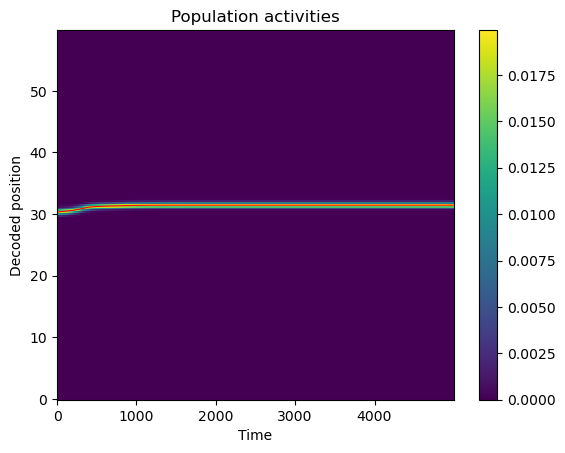

In [9]:
z = np.arange(T)
flipped_sorted_u_place_couple = record_place_r.T
plt.figure()
plt.pcolormesh(z, P_CANN.x, flipped_sorted_u_place_couple, shading='auto')
plt.plot(z, z_decode_net, color='r', label='Net decoding', linewidth=0.8)
plt.colorbar()  # Optional: Add a color bar for reference
plt.xlabel('Time')  # Optional: Add X axis label
plt.ylabel('Decoded position')  # Optional: Add Y axis label
plt.title('Population activities')  # Optional: Add title
plt.show()

<Figure size 640x480 with 0 Axes>

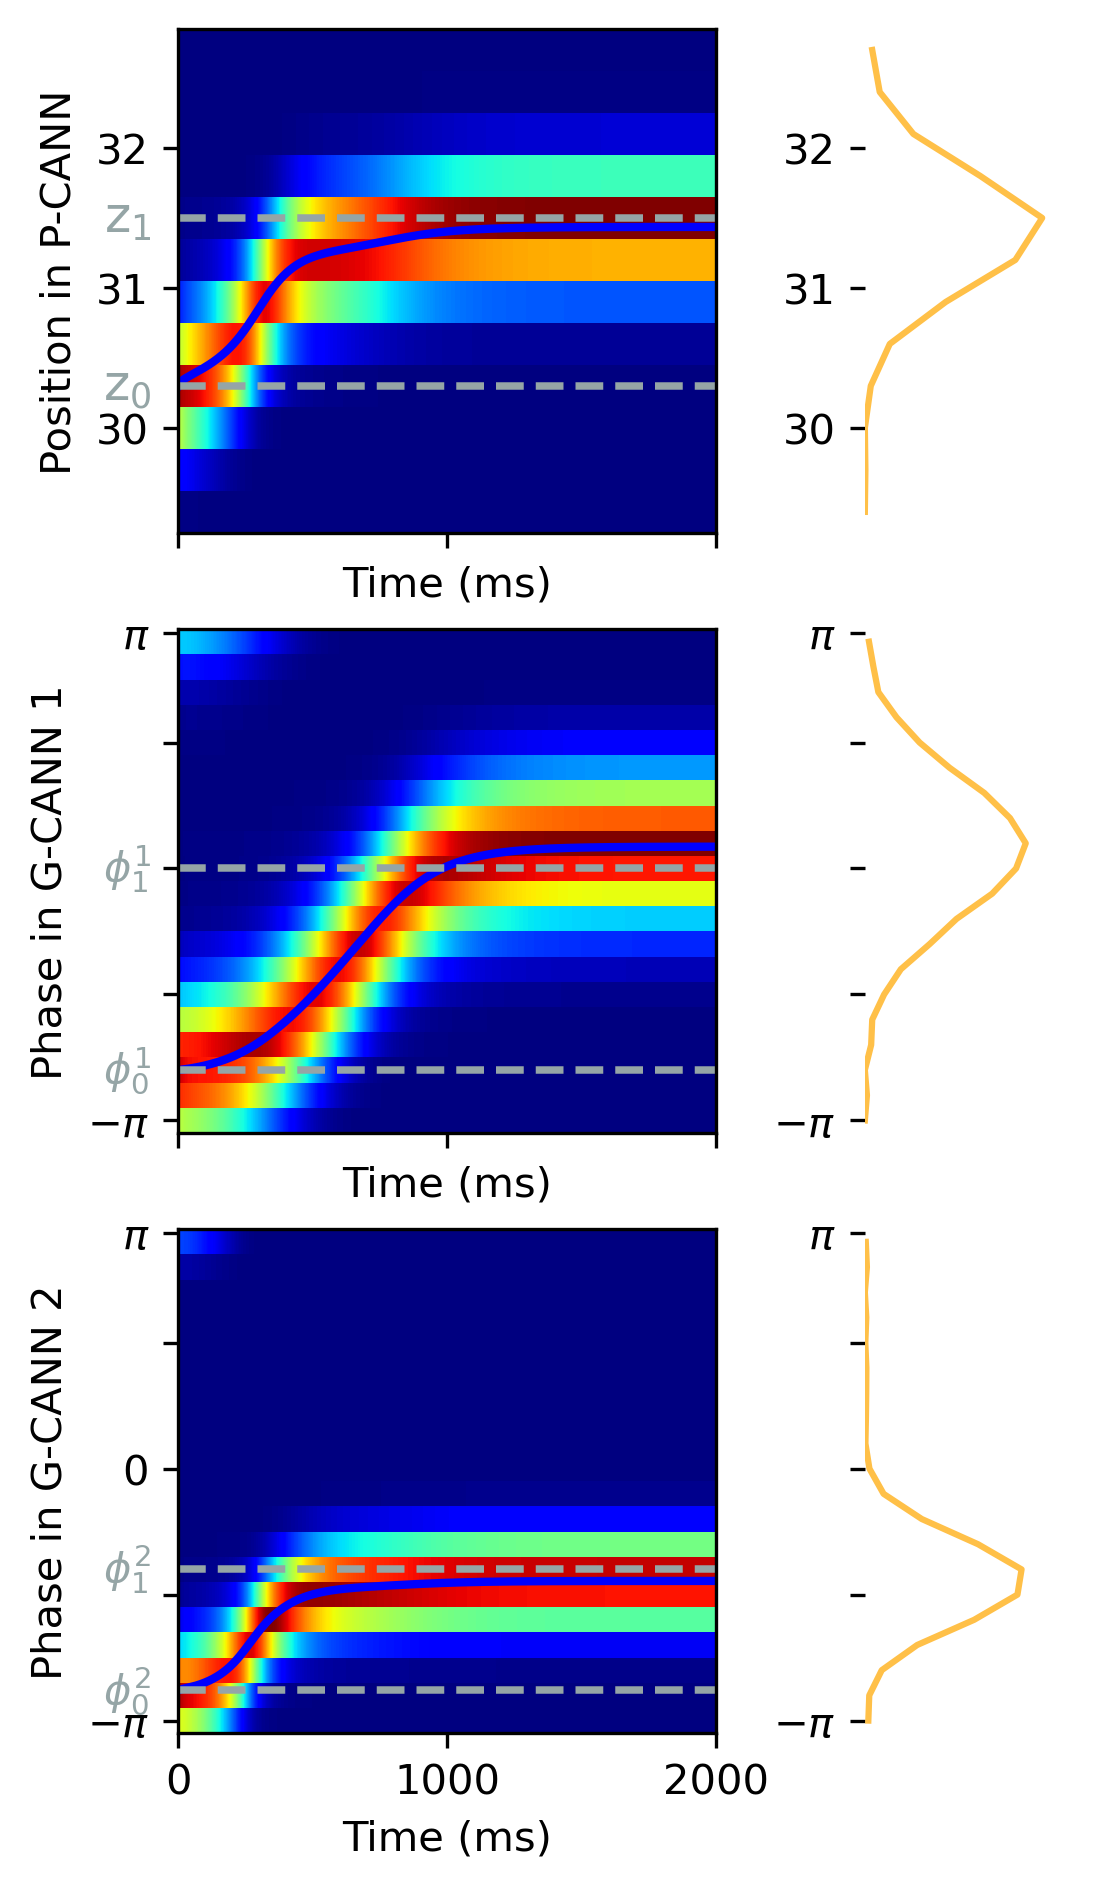

In [ ]:
from matplotlib import gridspec
import matplotlib.cm as cm

flipped_sorted_u_place_couple = record_place_r.T
flipped_sorted_u_grid_couple = record_grid_r.T

neural_index = np.arange(98, 110)
t_index = np.arange(2000)

phi_init = np.mod(z0 / Lambda, 1) * 2 * np.pi - np.pi
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi - np.pi


# Set a uniform x-axis range
xlim = (z[t_index[0]], z[t_index[-1]]+2)
xticks = [0, 1000, 2000]

plt.clf()
fig, axs = plt.subplots(3, 2, figsize=(3.8, 6.4), dpi=300, gridspec_kw={'width_ratios': [2.5, 1]}, sharex='col')

# First line: P-CANN
ax1, ax2 = axs[0]
im = ax1.pcolormesh(z[t_index], P_CANN.x[neural_index], flipped_sorted_u_place_couple[np.ix_(neural_index, t_index)], cmap='jet')
ax1.plot(z[t_index], z_decode_net[t_index], color='blue', linewidth=2, label='bump center')
ax1.axhline(z_truth, color="#95a5a6", linestyle='--', linewidth=1.8)
ax1.text(z[t_index[0]] - 100, z_truth, f'z$_{{{1}}}$', va='center', ha='right', color="#95a5a6", fontsize=12)
ax1.axhline(z0, color="#95a5a6", linestyle='--', linewidth=1.8)
ax1.text(z[t_index[0]] - 100, z0, 'z$_0$', va='center', ha='right', color="#95a5a6", fontsize=12)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Position in P-CANN')
ax1.set_yticks(np.arange(np.ceil(P_CANN.x[neural_index].min()), np.floor(P_CANN.x[neural_index].max())+1, 1))
ax1.set_xticks(xticks)
ax1.set_xlim(xlim)

ax2.plot(record_place_u[-1, neural_index], P_CANN.x[neural_index], color='#ffc048', label='final bump')
# ax2.legend(loc='best', fontsize=10)
ax2.set_ylim(ax1.get_ylim())
ax2.set_xlim(0, max(np.max(u_HPC_init[-1, neural_index]), np.max(record_place_u[-1, neural_index]), np.max(Ip[neural_index])) * 1.2)
ax2.set_aspect('auto')
ax2.set_xticks([])
ax2.set_facecolor('white')
for spine in ax2.spines.values():
    spine.set_visible(False)

# Second line
i = 0
ax1, ax2 = axs[1]
im = ax1.pcolormesh(z[t_index], G_CANNs[i].x, flipped_sorted_u_grid_couple[:,i,t_index], cmap='jet', shading='auto', linewidth=4)
ax1.plot(z[t_index], phi_decode_net[t_index,i], color='blue', linewidth=2)
ax1.axhline(phi_init[i], color="#95a5a6", linestyle='--', linewidth=1.8)
ax1.text(z[t_index[0]] - 100, phi_init[i], '$\\phi_{0}^{1}$', va='center', ha='right', color="#95a5a6", fontsize=10)
ax1.axhline(phi_truth[i], color="#95a5a6", linestyle='--', linewidth=1.8)
ax1.text(z[t_index[0]] - 100, phi_truth[i], '$\\phi_{1}^{1}$', va='center', ha='right', color="#95a5a6", fontsize=10)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Phase in G-CANN 1')
ax1.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi-0.2])
ax1.set_yticklabels(['$-\pi$', '', '', '', '$\pi$'])
ax1.set_xticks(xticks)
ax1.set_xlim(xlim)

curve_idx = -1
ax2.plot(record_grid_u[curve_idx, i], G_CANNs[i].x, color='#ffc048')
ax2.set_ylim(ax1.get_ylim())
ax2.set_xlim(0, max(np.max(u_grid_init[-1,i]), np.max(record_grid_u[-1,i]), np.max(Ig[i])) * 1.2)
ax2.set_aspect('auto')
ax2.set_xticks([])
ax2.set_facecolor('white')
ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi-0.2])
ax2.set_yticklabels(['$-\pi$', '', '', '', '$\pi$'])
for spine in ax2.spines.values():
  spine.set_visible(False)

# Third line
i = 2
ax1, ax2 = axs[2]
im = ax1.pcolormesh(z[t_index], G_CANNs[i].x, flipped_sorted_u_grid_couple[:,i,t_index], cmap='jet', shading='auto', linewidth=4)
ax1.plot(z[t_index], phi_decode_net[t_index,i], color='blue', linewidth=2)
ax1.axhline(phi_init[i], color="#95a5a6", linestyle='--', linewidth=1.8)
ax1.text(z[t_index[0]] - 100, phi_init[i], '$\\phi_{0}^{2}$', va='center', ha='right', color="#95a5a6", fontsize=10)
ax1.axhline(phi_truth[i], color="#95a5a6", linestyle='--', linewidth=1.8)
ax1.text(z[t_index[0]] - 100, phi_truth[i], '$\\phi_{1}^{2}$', va='center', ha='right', color="#95a5a6", fontsize=10)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Phase in G-CANN 2')
ax1.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi-0.2])
ax1.set_yticklabels(['$-\pi$', '', '0', '', '$\pi$'])
ax1.set_xticks(xticks)
ax1.set_xlim(xlim)

curve_idx = -1
ax2.plot(record_grid_u[curve_idx, i], G_CANNs[i].x, color='#ffc048', label='bump center')
# ax2.legend(loc='best', fontsize=10)
ax2.set_ylim(ax1.get_ylim())
ax2.set_xlim(0, max(np.max(u_grid_init[-1,i]), np.max(record_grid_u[-1,i]), np.max(Ig[i])) * 1.2)
ax2.set_aspect('auto')
ax2.set_xticks([])
ax2.set_facecolor('white')
ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi-0.2])
ax2.set_yticklabels(['$-\pi$', '', '', '', '$\pi$'])
for spine in ax2.spines.values():
  spine.set_visible(False)

plt.tight_layout(w_pad=0.1, h_pad=0.3)
plt.show()


## Fig3b

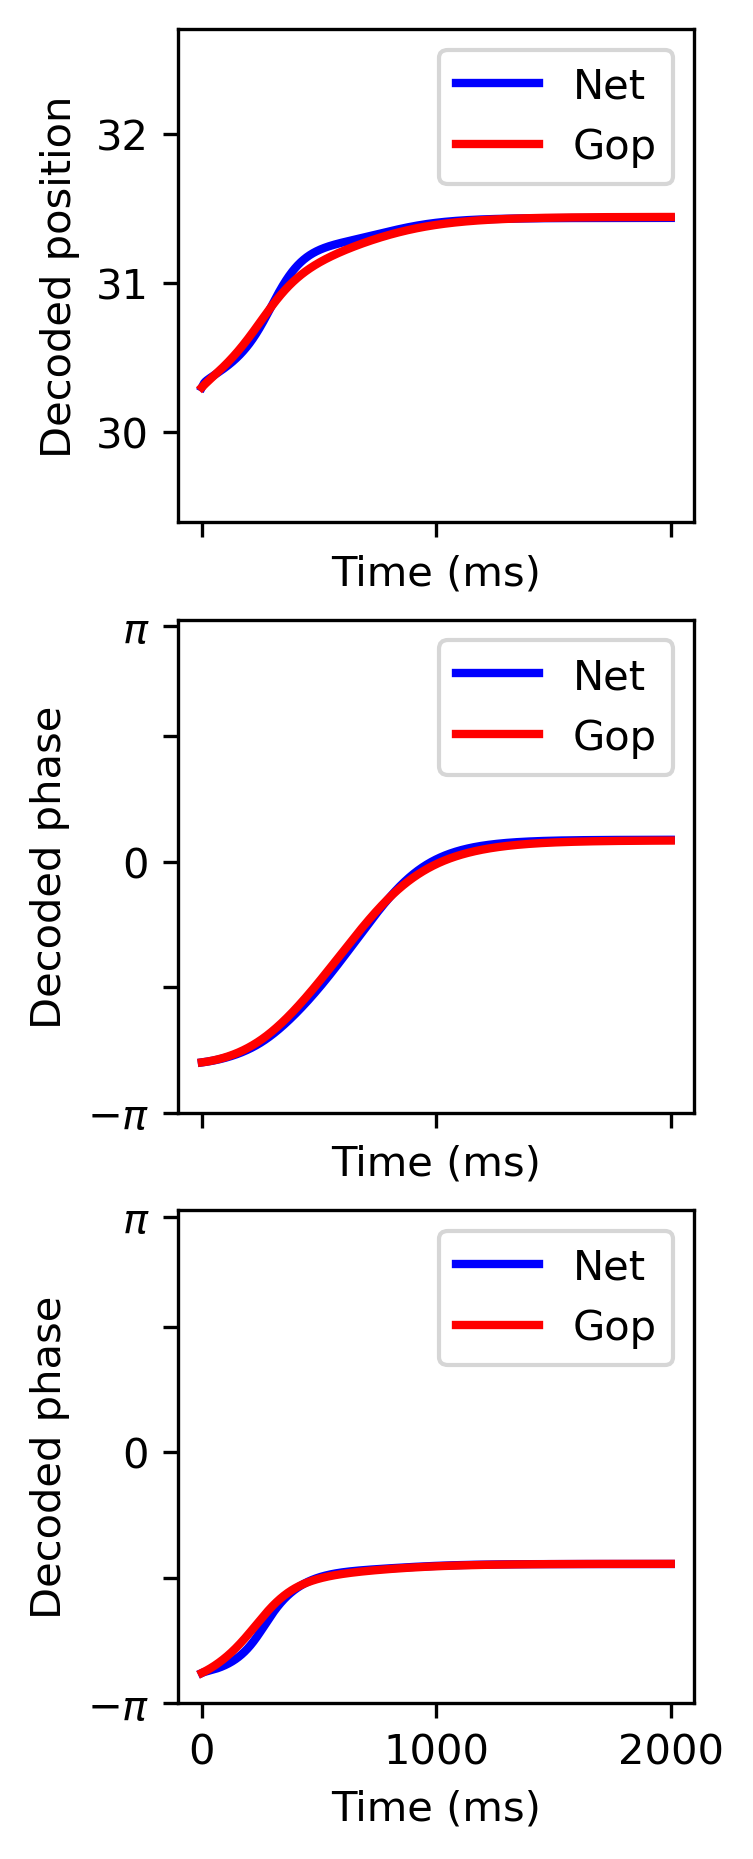

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(2.6, 6.3), dpi=300, sharex=True)

# First line: Position decoding
axs[0].plot(t_index, z_decode_net[t_index], label='Net', linewidth=2, color='blue')
axs[0].plot(t_index, z_decode_gop[t_index+1], label='Gop', linewidth=2, color='red')
axs[0].set_ylabel('Decoded position')
axs[0].set_yticks(np.arange(np.ceil(P_CANN.x[neural_index].min()), np.floor(P_CANN.x[neural_index].max())+1, 1))
axs[0].set_ylim(P_CANN.x[neural_index].min(), P_CANN.x[neural_index].max())
axs[0].legend()
axs[0].grid(False)
axs[0].set_xlabel('Time (ms)')

# Second line: G-CANN Phase Decoding
i = 0
axs[1].plot(t_index, phi_decode_net[t_index,i], label='Net', linewidth=2, color='blue')
axs[1].plot(t_index, phi_decode_gop[t_index+1,i]-np.pi, label='Gop', linewidth=2, color='red')
axs[1].set_ylabel('Decoded phase')
axs[1].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi-0.2])
axs[1].set_yticklabels(['$-\pi$', '', '0', '', '$\pi$'])
axs[1].set_ylim(G_CANNs[i].x.min(), G_CANNs[i].x.max()+0.2)
axs[1].legend()
axs[1].grid(False)
axs[1].set_xlabel('Time (ms)')

# Third line: G-CANN 3-phase decoding
i = 2
axs[2].plot(t_index, phi_decode_net[t_index,i], label='Net', linewidth=2, color='blue')
axs[2].plot(t_index, phi_decode_gop[t_index+1,i]-np.pi, label='Gop', linewidth=2, color='red')
axs[2].set_ylabel('Decoded phase')
axs[2].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi-0.2])
axs[2].set_yticklabels(['$-\pi$', '', '0', '', '$\pi$'])
axs[2].set_ylim(G_CANNs[i].x.min(), G_CANNs[i].x.max()+0.2)
axs[2].legend()
axs[2].grid(False)
axs[2].set_xlabel('Time (ms)')
axs[2].set_xticks([0, 1000, 2000])

plt.tight_layout(h_pad=0.4)
plt.show()
